# Finding the training images with a Web Scraper

Go to e926 and then use [this extension](https://chrome.google.com/webstore/detail/download-all-images/nnffbdeachhbpfapjklmpnmjcgamcdmm?hl=en) to download all the images.

The tags I used is dragon, solo, headshot_portrait

# Importing the images from the dataset folder

pathlib.Path() is a utility function that handles OS file paths. We are going to use it to access our home folder and list out all the files inside a folder.

The home folder for Windows is usually your `/User/Your-Name/`

In [ ]:
import tensorflow as tf
from pathlib import Path
import numpy as np
import os

print(tf.__version__)

2.8.0


In [ ]:
data_dir = os.path.join(Path.home(),'dataset','dragonfinder') # A folder called dataset in which has a folder called dragonfinder
print(data_dir)

/root/dataset/dragonfinder


Next, we use the .glob() function to select all the JPG image type, and count the number of images.

In [ ]:
data_dir = Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

1017

Now, we specify the input size for the input images, and some hyperparameters such as the batch size, and epochs (number of times a model observe the full training set).

In [ ]:
IMAGE_HEIGHT = 100
IMAGE_WIDTH = 150

BATCH_SIZE = 32

EPOCHS = 10

TRAIN_PERC = 0.8 # Use 80% of the images for training

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])

CLASS_NAMES = np.delete(CLASS_NAMES, 0)

print('The class names are: ', CLASS_NAMES)

# Why are there other class names, and not just dragons? 
# Honestly this was copy pasted code from Google's own project and 
# I don't know how to make Tensorflow know that 
# I just want it to recognize one type of class only

The class names are:  ['lion' 'dragon' 'deer']


In [ ]:
train_size = int(TRAIN_PERC * image_count)

test_size = int((1-TRAIN_PERC) * image_count)

# Creating a Data Pipeline

To create a data pipeline, We start by providing the list of image paths in the `tf.data.Dataset.list_files()` function

In [ ]:
import tensorflow as tf

all_files = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [ ]:
for f in all_files.take(5):
    print(f.numpy())

b'/root/dataset/dragonfinder/dragon/472e7b5f2d075955d8a305e3c68aa62b-jpg.jpg'
b'/root/dataset/dragonfinder/dragon/310c2f8984d3fc5e5888a0015b34a6ff-jpg.jpg'
b'/root/dataset/dragonfinder/dragon/8ad2af6d60d10859a806f14e982d0743-jpg.jpg'
b'/root/dataset/dragonfinder/dragon/fb37841a3e63cb966541c241b3d4ad76-jpg.jpg'
b'/root/dataset/dragonfinder/dragon/fd924022299fa0932a038b267ba580a3-jpg.jpg'


Shuffle the image paths and split them into a train set and a test set 

(I don't know what the original author meant by this comment, so I'll just paste it here in the hopes that I'll get it in the future and expand on it)

In [ ]:
all_files = all_files.shuffle(buffer_size = image_count)

train_files = all_files.take(train_size)

test_files = all_files.skip(train_size)

Next, we create functions to load the images into a tensor and process their corresponding labels.

The `parse_image()` function reads the image paths and output the tensor of desired size

The `get_label()` function extracts the labels and converts them into one-hot encoded format

In [ ]:
def parse_img(img):
    # load the raw data from the file as a string
    img = tf.io.read_file(img)
    
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # resize the image to the desired size.
    return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])

In [ ]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

In [ ]:
def process_path(file_path):
    label = get_label(file_path)
    
    img = parse_img(file_path)
    
    return img, label

In [ ]:
train_dataset = train_files.map(process_path)

test_dataset = test_files.map(process_path)

In [ ]:
for image, label in train_dataset.take(1):
    print("Image shape: ", image.numpy().shape)
    
    print("Label: ", label.numpy())

Image shape:  (100, 150, 3)
Label:  [False  True False]


Create batches of samples based on the BATCH_SIZE hyperparameter.

In [ ]:
train_dataset_batch = train_dataset.batch(BATCH_SIZE)

test_dataset_batch = test_dataset.batch(BATCH_SIZE)

In [ ]:
image_batch, label_batch = next(iter(train_dataset_batch))

In [ ]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        
        plt.imshow(image_batch[n])
        
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        
        plt.axis('off')

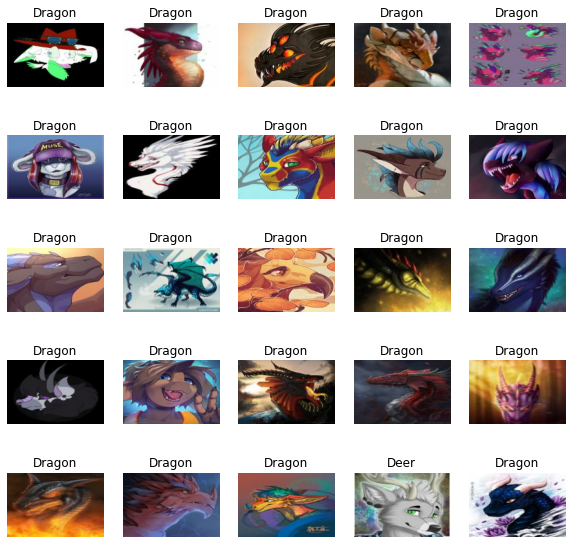

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

# Training the Model (Finallyyyy)

We will define a model with 7 layers to classify the images

It is made up of 3 convolutional layers, 2 max pooling layers, and 2 dense layers.

In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

model.add(tf.keras.layers.Flatten())

# Dense layers

model.add(tf.keras.layers.Dense(64, activation='relu'))

model.add(tf.keras.layers.Dense(3))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 98, 148, 32)       896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 49, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 47, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 23, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 21, 34, 64)        36928     
                                                                 
 flatten_3 (Flatten)         (None, 45696)            

Next, we define the training configuration, here we use 'adam' as the optimizer, cross entropy as the loss function, and accuracy as our evaluation metric

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

The .fit starts the training and all the training information will be stored in a 'history' variable.

In [ ]:
history = model.fit(train_dataset_batch, epochs=EPOCHS, validation_data=test_dataset_batch) 

# This one cell will be the one that actually starts the training, so if you're running this, go get a coffee or something 

Epoch 1/10
26/26 [==============================] - 29s 1s/step - loss: 0.9449 - accuracy: 0.7503 - val_loss: 0.6861 - val_accuracy: 0.7535
Epoch 2/10
26/26 [==============================] - 20s 763ms/step - loss: 0.6721 - accuracy: 0.7712 - val_loss: 0.6066 - val_accuracy: 0.7958
Epoch 3/10
26/26 [==============================] - 20s 762ms/step - loss: 0.6543 - accuracy: 0.7638 - val_loss: 0.6483 - val_accuracy: 0.7394
Epoch 4/10
26/26 [==============================] - 20s 767ms/step - loss: 0.6403 - accuracy: 0.7565 - val_loss: 0.7357 - val_accuracy: 0.7289
Epoch 5/10
26/26 [==============================] - 20s 760ms/step - loss: 0.5990 - accuracy: 0.7811 - val_loss: 0.4913 - val_accuracy: 0.8028
Epoch 6/10
26/26 [==============================] - 20s 766ms/step - loss: 0.5426 - accuracy: 0.7860 - val_loss: 0.4981 - val_accuracy: 0.7958
Epoch 7/10
26/26 [==============================] - 20s 764ms/step - loss: 0.4761 - accuracy: 0.8192 - val_loss: 0.4151 - val_accuracy: 0.8310
Ep

We can use the information stored in the 'history' variable to visualize the trend of training loss.

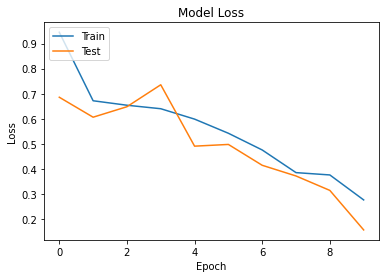

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Again, we plot a graph that shows the accuracy of model in each epoch using information from the 'history' variable.

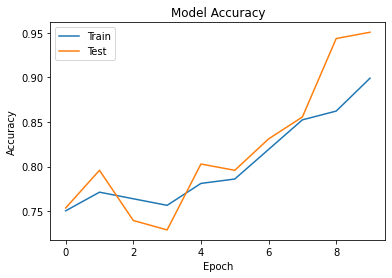

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluation

We can use the function provided by sklearn to produce a Confusion Matrix and a classification report to check the performance of our model.

In [ ]:
test_pred = []
test_actual = []

for features, labels in test_dataset_batch:
    scores = model.predict(features)
    pred = np.argmax(scores, axis=1)
    
    test_pred = test_pred + list(pred)
    test_actual = test_actual + list(np.argmax(labels.numpy(), axis=1))

In [ ]:
print(test_pred)

[1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 2, 0, 1, 0, 1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
print(test_actual)

[1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 0, 2, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 2, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(test_actual, test_pred))

[[ 28  11   0]
 [  1 216   0]
 [  0   6  22]]


In [ ]:
print(classification_report(test_actual, test_pred))

              precision    recall  f1-score   support

           0       0.97      0.72      0.82        39
           1       0.93      1.00      0.96       217
           2       1.00      0.79      0.88        28

    accuracy                           0.94       284
   macro avg       0.96      0.83      0.89       284
weighted avg       0.94      0.94      0.93       284



# Inference

Once the model is trained, we can use it to predict a single image or batch of images.

We can use the parse_img() function that we define above to load the image, and pass them as a tensor to the model.predict() function.

In [ ]:
inference_image = os.path.join(data_dir, 'dragon', '0f8ba97e062007a512d61e5b299d8b69-jpg.jpg')

In [ ]:
test_image = parse_img(inference_image)

prediction_score = model.predict(np.expand_dims(test_image, 0))

prediction_score

array([[-0.50674504,  3.0739255 , -2.0485716 ]], dtype=float32)

When we perform a single sample prediction, the scores of each class are retrieved. In order to get the probability of the prediction, we squash the scores using the Softmax function and get the predictions probability.

In [ ]:
softmax = tf.keras.layers.Softmax()
prediction_probability = softmax(prediction_score)

prediction_probability.numpy()

array([[0.02694576, 0.96728814, 0.00576612]], dtype=float32)

Use np.argmax() function to get the index of element that contains the maximum value (the output with the highest probability).

In [ ]:
prediction_class = np.argmax(prediction_probability, axis=1)

prediction_class

array([1])

In [ ]:
CLASS_NAMES[prediction_class]

array(['dragon'], dtype='<U18')

**Front-end Usage for the Model**

[The discord bot's invite link](https://discord.com/oauth2/authorize?client_id=940585410751508510&permissions=534723950656&scope=bot)

The above link invites the bot with most messages permissions


---


Click [here](https://discord.gg/rShZehTsZn) to join the Dragonfinder's Lair Discord Server



---



The source code for the Github bot is available [here](https://github.com/StreamFroster/dragonfinder)